In [61]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.decomposition import PCA
import scipy.optimize

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_mat = os.path.join(os.path.join(path2p, "data/"), "sim_ds_mat")
pwd_h5 = os.path.join(os.path.join(path2p, "data/"), "sim_ds_h5")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_mat
from corr_lib import sprMat
from qt_wrapper import gui_fpath

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/nest-mesoscopic-metric-test/codes/lib


## 0. Loading data

In [14]:
# Read LVM file from command line
data_path = gui_fpath("Select data directory", "./")
data, behaviour = read_mat(data_path)

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mtp/mtp_7/mtp_7_2016_02_19_a
Loaded neuronal data with (nTrials, nTimes, nChannels)= (885, 201, 12)


# 1. Autoregression

What to include into model:
1. Autoregressive Dynamics
$$\vec{x}(t+1) = A\vec{x}(t)$$
2. Neural noise, to model input from external sources
$$\vec{x}(t+1) = A\vec{x}(t) + \nu, \;\;\;\;\; \nu \sim \mathcal{N}(\vec{\mu}, \Sigma)$$
3. Input and input-coupling
$$ \vec{x}(t+1) = A\vec{x}(t) + B\vec{u}(t) + C \vec{x}(t) \vec{u}(t) + \nu$$
4. Observable convolution
$$
\begin{eqnarray}
  \tau \dot{y} &=& -y + x \\
  \vec{y}(t+1) &\approx& \alpha \vec{x}(t) + (1 - \alpha) \vec{y}(t), \;\;\;\;\; \alpha = \frac{\Delta t}{\tau}
\end{eqnarray}$$

**TODO**:
* See what tools for autoregressors exist
* Read literature on DCM, understand how it works, how it is different from autoregressor
* For observable autoregressor, is it not equivalent to simply deconvolving data and then using basic deconvolved?
   $$x(t) = y(t) + \frac{y(t+1) - y(t)}{\alpha}$$
   * Ask Yaro if he thinks this makes sense
   * Look for most optimal deconvolution tool for this process

In [92]:
def unpack(Aarr):
    return Aarr.reshape(nChannels, nChannels)

# def L(Aarr):
#     Amat = unpack(Aarr)
#     data_guess = data.dot(Amat.T)
#     residue = np.linalg.norm(data[:, 1:, :] - data_guess[:, :-1, :])
#     return residue

d_0 = data[:, :-1, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
d_1 = data[:, 1:, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
len_d = d_0.shape[1]

D1 = np.linalg.norm(d_1)**2
D10  = np.einsum('ij, kj', d_1, d_0)
D00 = np.einsum('kj, lj', d_0, d_0)

def reg(Amat):
    return 5.0*np.sum(np.abs(Amat))

def L2_fast(Aarr):
    Amat = unpack(Aarr)
    B = -2*np.einsum('ij, ij', Amat, D10)
    C = np.einsum('ik,il,kl', Amat, Amat, D00)
    return D1 + B + C + reg(Amat)

True
Optimization terminated successfully.
7.1966578268078045 compared to 42.93947805258411


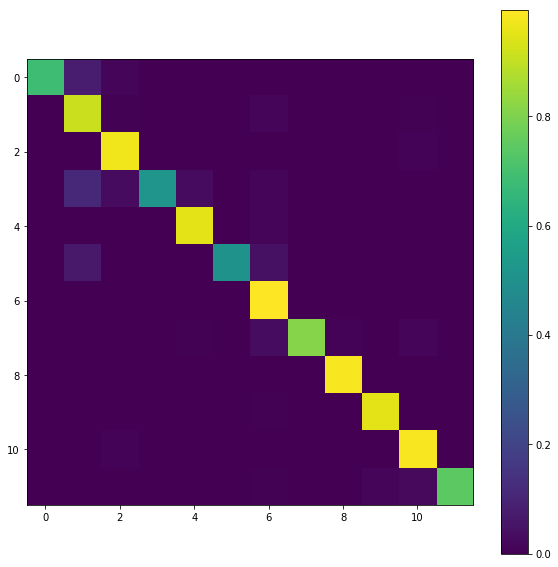

In [93]:
# Example 1:
A0arr = np.random.normal(0, 1, nChannels**2)

bounds = [(0, 10) for i in range(nChannels**2)]
min_obj = scipy.optimize.minimize(L2_fast, A0arr, bounds=bounds, method='SLSQP')

print(min_obj.success)
print(min_obj.message)

A = unpack(min_obj.x)
A[A < 1.0e-10] = 0

# Compute fitness
L2_without_reg = np.sqrt(min_obj.fun - reg(A))
print(L2_without_reg, "compared to", np.linalg.norm(data[:, 1:, :]))

plt.figure(figsize=(10,10))
plt.imshow(unpack(min_obj.x))
plt.colorbar()
plt.show()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.684697,0.078710,0.011882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.913134,0.005526,0.000000,0.000000,0.000000,0.014879,0.000000,0.000000,0.000000,0.005264,0.000000
2,0.000000,0.000000,0.972546,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008297,0.000000
3,0.000000,0.115583,0.028348,0.516885,0.030154,0.000000,0.013384,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.952941,0.000000,0.011978,0.000000,0.000000,0.000000,0.001988,0.000000
5,0.000000,0.066058,0.000539,0.000000,0.000000,0.505086,0.045343,0.000000,0.000000,0.003748,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.993532,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.005754,0.000000,0.034453,0.812878,0.009532,0.000000,0.018433,0.000000
8,0.000000,0.000075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.982514,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004075,0.000000,0.000000,0.952988,0.000000,0.000000


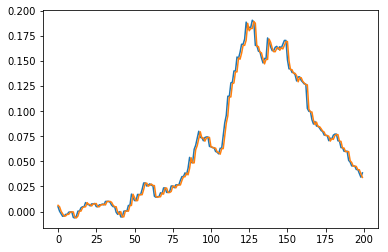

In [102]:
display(pd.DataFrame(A))

N_CH = 6
plt.figure()
plt.plot(data[0, 1:, N_CH])
plt.plot(data[0, :-1, :].dot(A.T)[:, N_CH])
plt.show()

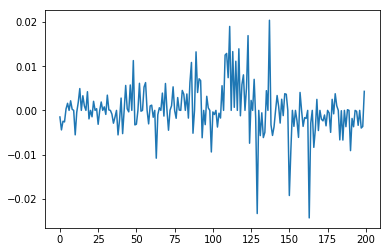

In [103]:
plt.figure()
plt.plot(data[0, 1:, 6] - data[0, :-1, 6])
plt.show()